#Dataset creation using GeoTile

This guide briefly shows how to take a large GeoTiff of satellite Imagery and a corresponding GeoTiff segmentation mask, and convert it into a dataset that can be used for training an ML model. The data used in this notebook corresponds with this project.  You will need two files to run this notebook:

* Cropped Harmonized Sentinel 2 image
* Cropped well pad segmentation mask

Both can be found in [this Google Drive folder](https://drive.google.com/drive/folders/1FV4KqhB5Nm_gxwxtnwm6kw8zZSsZaI6Q?usp=sharing). It is suggested that you create a shortcut to this folder rather than directly downloading.



In [1]:
from IPython.display import clear_output
!pip install geotile
clear_output()

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
from geotile import GeoTile
import rasterio
from matplotlib import pyplot as plt
import numpy as np
import os

#### The first step is to define the folder path to both the satellite imagery and the corresponding mask. You can create a Google Drive shortcut for the well pad data (and leave these lines untouched), or define the path to your own custom GeoTiff data.

In [4]:
image_for_tiling = r"/content/gdrive/MyDrive/GeoTile Examples/wellpad_sentinel_cropped.tif"
mask_for_tiling = r"/content/gdrive/MyDrive/GeoTile Examples/wellpad_sentinel_cropped_mask.tif"

### Next we define a function to visualize our GeoTiff data.

In [5]:
def display_tiff(data=None,tiff_file_path=None, mask=False):

  if tiff_file_path is not None:
    data = None
    with rasterio.open(tiff_file_path) as src:
      if not mask:
        data = np.array([src.read(3),src.read(2),src.read(1)])
      else:
        data = src.read(1)
  # Read the raster data
  if not mask:
    data = np.transpose(data, (1, 2, 0))
    min_val = np.min(data)
    max_val = np.max(data)

    # Perform min-max scaling to normalize the array
    data = (data - min_val) / (max_val - min_val)
    print(data.shape)
    # Visualize the data
    plt.imshow(data)
    plt.show()
  else:
    print(data.shape)
    # Visualize the data
    plt.imshow(data, cmap="gray")
    plt.show()

### Data Visualizations

We can visualize our data to confirm that displays the imagery we intended for creating our dataset. In order to proceed we must ensure that both images cover the same region of interest and have the same spatial resolution.

(4038, 5993, 3)


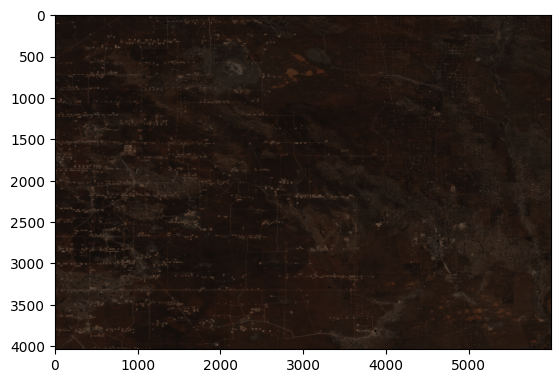

In [6]:
display_tiff(tiff_file_path=image_for_tiling)

(4096, 6144)


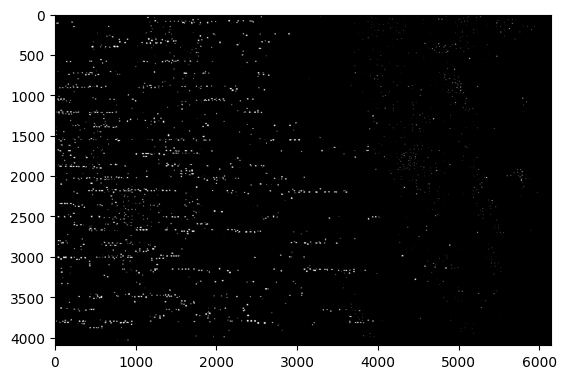

In [7]:
display_tiff(tiff_file_path=mask_for_tiling, mask = True)

##Generating Tiles
We can immediately start generating tiles using tools from the [GeoTile library](https://geotile.readthedocs.io/en/latest/index.html). We can define the pixel width/height of our tiles with tile_x and tile_y parameters. We can also define the stride (which indicates how spread out the tiles are). Setting the stride equal to the tile width ensures no overlap between tiles. The result is stored as a GeoTile object that offers other functions for transforming and manipulating the data.

In [8]:
#Create the GeoTile object for the image tiles
wellpad_tiles = GeoTile(image_for_tiling)
#Generate the image tiles
wellpad_tiles.generate_tiles(save_tiles=False, tile_x=256, tile_y=256, stride_x=256, stride_y=256)
#Optional normalization step
wellpad_tiles.normalize_tiles()

#Create the GeoTile object for the segmentation mask tiles
wellpad_masks = GeoTile(mask_for_tiling)
#Generate the mask tiles
wellpad_masks.generate_tiles(save_tiles=False,out_bands = [1], tile_x=256, tile_y=256, stride_x=256, stride_y=256)
#Optional normalization step
wellpad_masks.normalize_tiles()

#One important side note...
 All the data stored within the GeoTile object can be accessed as a numpy array via the `tile_data` variable.  This variable is mutable which means you can alter its value at any time. For example you could apply preproccessing using a custom preproccessing function like this:

`wellpad_tiles.tile_data = custom_preproccessing(wellpad_tiles.tile_data)`

Where 'custom_preprocessing()' is a function that takes in the dataset as a numpy array and returns a numpy array of the same shape.

In [9]:
print(type(wellpad_tiles.tile_data),wellpad_tiles.tile_data.shape)

<class 'numpy.ndarray'> (384, 256, 256, 6)


#Saving the tiles
Next we can save our tiles to their respective folders. By specifying the suffix we can create a naming convention to identify the image and mask tiles that corresponds. Here we save the tiles to the local Colab storage, but you can also specify a Google Drive location.

In [10]:
wellpad_masks.save_tiles("/content/dataset/masks/", suffix="_mask")
wellpad_tiles.save_tiles("/content/dataset/tiles/", suffix="_tile")

#Organize data into Training & Validation sets

There are many ways to organize the training data, but this method works in conjunction with training the the HLS foundation model.

In [11]:
import os
import random
import shutil

# Moves the selected files to the destination folder
def move_tiles_to_folder(file_list, destination_folder):
  for file in file_list:
      mask_file = file[:-8] + "mask.tif"
      tile_path = os.path.join(tile_folder, file)
      mask_path = os.path.join(mask_folder, mask_file)
      tile_dest = os.path.join(destination_folder, file)
      mask_dest = os.path.join(destination_folder, mask_file)
      shutil.move(tile_path, tile_dest)
      shutil.move(mask_path, mask_dest)

validation_split = .15

tile_folder = '/content/dataset/tiles'
mask_folder = '/content/dataset/masks'
training_folder = '/content/dataset/training'
validation_folder = '/content/dataset/validation'

try:
  os.mkdir(training_folder)
  os.mkdir(validation_folder)
except:
  pass

tile_files = os.listdir(tile_folder)
mask_files = os.listdir(mask_folder)

num_of_validations = int(len(tile_files)*validation_split)

# Randomly select files to move
selected_files = random.sample(tile_files, num_of_validations)
move_tiles_to_folder(selected_files,validation_folder)

selected_files = os.listdir(tile_folder)
move_tiles_to_folder(selected_files,training_folder)

os.rmdir(tile_folder)
os.rmdir(mask_folder)

The resulting dataset can be moved to a desired destination folder. It is recommended that it is stored in a Google Drive folder.

In [14]:
source_folder = '/content/dataset'
destination_folder = '/content/gdrive/MyDrive/HLS foundation guide/'

shutil.move(source_folder, destination_folder)

'/content/gdrive/MyDrive/HLS foundation guide/dataset'

##Find Mean and Standard Deviation of the data.

When working with the HLS foundation model, it is important to know the statistics of the dataset.

In [30]:
num_of_channels=6
tile_stats = wellpad_tiles.tile_data.reshape(-1,num_of_channels)

In [31]:
mean = np.mean(tile_stats,axis=0)
std = np.std(tile_stats,axis=0)

In [32]:
print(mean)

[0.08285756 0.09015894 0.14294316 0.26300612 0.25897524 0.21503   ]


In [33]:
print(std)

[0.03269446 0.03606708 0.04953382 0.07931096 0.06092547 0.05726682]


##Create Normalized Mosiac for running inferences

When generating an inference on an image, it is important that the imagery has the same preproccessing and normalization as the training data.

In [35]:
from geotile import mosaic

def normalized_mosiac(path_to_geotiff,output_path):
  gt = GeoTile(image_for_tiling)
  gt.generate_tiles(save_tiles=False, tile_x=256, tile_y=256, stride_x=256, stride_y=256)
  gt.normalize_tiles()
  gt.save_tiles("/content/norm_tiles")
  mosaic("/content/norm_tiles", output_path)

normalized_mosiac(image_for_tiling,output_path = "/content/geotiff_normalized.tif")